<h1><center> Simulation and Monte-Carlo<br><br>
Self-avoiding random walks <br><br> Gabriel Romon</center></h1>


<div class="alert alert-block alert-danger"> Make sure you have the latest version of `matplotlib` and `numpy` !
<br><br>
When running all the cells, please wait 3-10 minutes, as some are quite computationally intensive.
<br><br>
This notebook is meant to be read as an .ipynb file. Do not convert it to HTML or Tex, or you will lose interactivity.
</div>

# Table of contents (interactive !)

- [Introduction](#1)
    - [Simple random walks over $\mathbb Z^d$](#11)
    - [Self-avoiding random walks over $\mathbb Z^d$](#12)
<br><br>
- [A first simulation algorithm](#2)
    - [Principle](#21)
    - [Analysis](#22)
<br><br>
- [Simulation via rejection sampling](#3)
    - [Principle](#31)
    - [Analysis](#32)
<br><br>
- [Estimation of squared end-to-end distance via importance sampling](#4)
    - [Principle](#41)
    - [Analysis](#42)
<br><br>
- [Simulation via the pivot algorithm](#5)
    - [Dimerization](#51)
    - [The pivot algorithm](#52)
    - [Use of pivot for estimation](#53)
<br><br>
- [Bibliography](#6)


Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<a id = "1"></a>

# Introduction
<a id = "11"></a>

### Simple random walks over $\mathbb Z^d$

A **simple random walk over $\mathbb Z^d$** is a sequence $(x_k)_{k\in \mathbb N}$ of elements of $\mathbb Z^d$ such that $x_0 = 0$ and $\forall k \in \mathbb N, \|x_{k+1}-x_k\|_2 = 1$.<br>
A **simple random walk of length $n$** is a $n+1$-tuple $(0,x_1,\ldots,x_n)\in (\mathbb Z^d)^{n+1}$ such that $\forall k \in \mathbb \{0,\ldots, n-1\}, \|x_{k+1}-x_k\|_2 = 1$. <br>
Let $\operatorname{SRW}(n)$ be the set of simple random walks of length $n$. Let $e_i$ denote the $i$-th element of the canonical basis of $\mathbb R^d$. Let $\epsilon_0,\ldots,\epsilon_{n-1}$ be i.i.d random vectors with uniform distribution over the set $\{\pm e_i, 1\leq i \leq d\}$ and define $X_0=0, \; X_k = X_{k-1} + \epsilon_{k-1}$ for $k\in \{1,\ldots,n\}$. Then $(X_0,\ldots,X_n)$ is a random vector with uniform  distribution over $\operatorname{SRW}(n)$.
***
We have implemented below a function `simpl_rnd_walk(n)` that generates elements in $\operatorname{SRW}(n)$ **uniformly** (that is to say with equal probability).

For most of our work, **a random walk of length $n$ is implemented as two lists** `x` and `y` of length $n+1$. `(x[i], y[i])` are the coordinates of the $i+1$-th site of the walk.

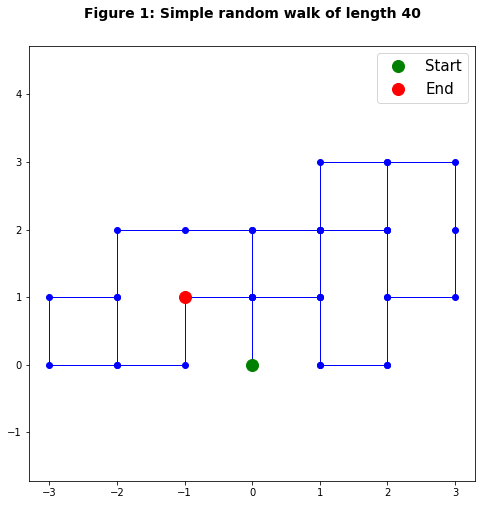

In [2]:
def simpl_rnd_walk(n):
    """
    Generates a simple random walk of length n
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y) (list, list): Random walk of length n
    """
    x, y = [0], [0]
    deltas = [(1,0), (0,1), (-1,0), (0,-1)] #possible directions for the 2D lattice
    for _ in range(n):
        dx, dy = deltas[np.random.randint(0,4)]   #direction chosen at random
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
    return x, y

def plot_simpl_rnd_walk(n):
    """
    Plots a simple random walk of length n
    
    Args:
        n (int): the length of the walk
    Returns:
        Plot of a simple random walk of length n
    """
    x, y = simpl_rnd_walk(n)
    plt.figure(figsize = (8, 8))
    plt.plot(x, y, 'bo-', linewidth = 1)
    plt.plot(0, 0, 'go', ms = 12, label = 'Start')
    plt.plot(x[-1], y[-1], 'ro', ms = 12, label = 'End')
    plt.axis('equal')
    plt.legend(fontsize=15)
    plt.title('Figure 1: Simple random walk of length ' + str(n), fontsize=14, fontweight='bold', y = 1.05)
    plt.show()

plot_simpl_rnd_walk(40)

<a id = "12"></a>
### Self-avoiding random walks over $\mathbb Z^d$

A **self-avoiding random walk (SAW) over $\mathbb Z^d$** is a simple random walk such that all the $x_k$ are distinct.<br>
A **self-avoiding random walk of length $n$** is a simple random walk of length $n$ where all the $x_k$ are distinct.<br>
Let $\operatorname{SAW}(n)$ be the set of self-avoiding walks of length $n$.

SAWs have received the attention of researchers in various fields (biology, chemisty, physics) because they provide a simple model for chain polymers such as polyester and polyethylene. In such long molecules, the force of repulsion between nonadjacent monomers become very strong when their distance is below a given threshold, hence the non-intersecting nature of SAWs. [[1]](#6)

Seemingly simple considerations such as the cardinality of $\operatorname{SAW}(n)$ and the simulation of SAWs have been the subject of research since the 1950's. 

The exact values of $c_n := \left|\operatorname{SAW}(n)\right|$ are only known for small $n$ and $d$. It is not difficult to get bounds on $c_n$. Walks that progress at each step in one of the $d$ positive directions are obviously SAWs, so one gets $c_n\geq d^n$. If one considers walks where $x_{k}\neq x_{k-1}$ for all $k\in \{1,\ldots,n\}$, there are $2d$ possible choices for $x_0$, and at most $2d-1$ choices for each of the following steps, thus $c_n\leq 2d (2d-1)^{n-1}$.

Besides, if one considers $(x_0,\ldots, x_{n+m})$ a SAW of length $n+m$, then $(x_0,\ldots, x_n)\in \operatorname{SAW}(n)$ and the translation of $(x_{n},\ldots, x_{n+m})$ at the origin is in $\operatorname{SAW}(m)$. This clearly provides an injection of $\operatorname{SAW}(n+m)$ into $\operatorname{SAW}(n)\times \operatorname{SAW}(m)$, thus $c_{n+m}\leq c_n c_m$. As a result, $\log c_n$ is subadditive, and a standard result proves that $\frac{\log c_n}n$ converges to its infimum, thus $c_n^{1/n}$ converges as well to its infimum. <br> 
$\mu:= \lim_n c_n^{1/n}$ is known as the **connective constant**. The previous bounds yield $$\frac{\ln(2d)}n + \frac{n-1}n \ln(2d-1) \geq \frac{\log c_n}n \geq \ln d$$
Since $\ln \mu$ is the infimum of $\frac{\ln c_n}n$, one gets $\ln(2d-1)\geq \ln \mu \geq \ln d$, thus $d\leq \mu \leq 2d-1$.

It is believed that the asymptotic behaviour of $c_n$ for $d\neq 4$ is $c_n\sim A\mu^n n^{\gamma-1}$ where $A, \mu, \gamma$ are constants that depend on $d$. $\gamma$ is known as the **critical exponent**.<br> 
For $d=2$, it is conjectured that $\gamma=\frac{43}{32}$ and it is known that $\mu\in [2.62, 2.68]$.<br> 
For $d=3$, simulations suggest that $\gamma \approx 4.68$ and $\mu \approx 1.16$.<br> 
For $d=4$, the conjectured behaviour is $c_n \sim A\mu^n (\log n)^{\frac 14}$.<br> 
For $d>4$, it is conjectured that $\gamma =1$.
[Source](https://www.math.ubc.ca/~slade/spa_proceedings.pdf)

Since there are $(2d)^n$ simple random walks, these estimates imply that the proportion of self-avoiding walks goes to $0$ quite fast as $n$ goes to $\infty$. **In the special case $d=2$, the proportion of self-avoiding walks** is $\approx 0.65^n n^{0.34}$ (up to the constant $A$).

**Unless specified, we consider $d=2$ in the rest of this report.**




<a id = "2"></a>
# A first simulation algorithm

<a id = "21"></a>
### Principle

This algorithm is referred to in [[2]](#6) as the **Myopic Self-Avoiding Walk**. At each step, the algorithm chooses the next site uniformly at random from the neighbors of the current site that were never visited before. 

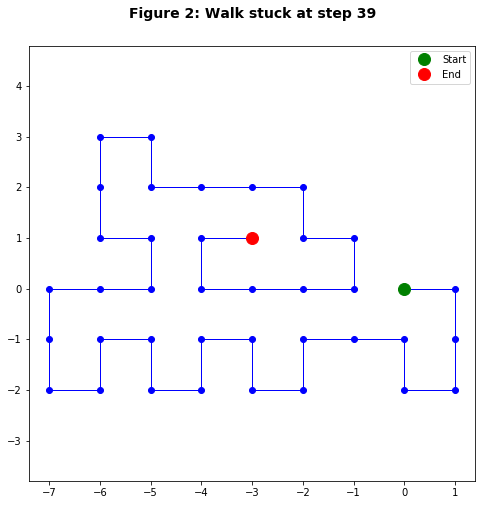

In [3]:
def myopic_saw(n):
    """
    Tries to generate a SAW of length n using the myopic algorithm
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y, stuck, steps) (list, list, bool, int): 
            (x,y) is a SAW of length <= n
            stuck is 1 if the walk could not terminate
            steps is the number of sites of the final walk
    """    
    x, y = [0], [0]
    positions = set([(0,0)])  #positions is a set that stores all sites visited by the walk
    stuck = 0
    for i in range(n):
        deltas = [(1,0), (0,1), (-1,0), (0,-1)]
        deltas_feasible = []  #deltas_feasible stores the available directions 
        for dx, dy in deltas:
            if (x[-1] + dx, y[-1] + dy) not in positions:  #checks if direction leads to a site not visited before
                deltas_feasible.append((dx,dy))
        if deltas_feasible:  #checks if there is a direction available
            dx, dy = deltas_feasible[np.random.randint(0,len(deltas_feasible))]  #choose a direction at random among available ones
            positions.add((x[-1] + dx, y[-1] + dy))
            x.append(x[-1] + dx)
            y.append(y[-1] + dy)
        else:  #in that case the walk is stuck
            stuck = 1
            steps = i+1
            break  #terminate the walk prematurely
        steps = n+1
    return x, y, stuck, steps

def plot_saw(n):
    """
    Plots the output of the myopic algorithm
    
    Args:
        n (int): the length of the walk
    Returns:
        Plot of the output of the myopic algorithm
    """    
    x, y, stuck, steps = myopic_saw(n)
    plt.figure(figsize = (8, 8))
    plt.plot(x, y, 'bo-', linewidth = 1)
    plt.plot(0, 0, 'go', ms = 12, label = 'Start')
    plt.plot(x[-1], y[-1], 'ro', ms = 12, label = 'End')
    plt.axis('equal')
    plt.legend()
    if stuck:
        plt.title('Figure 2: Walk stuck at step ' + str(steps), fontsize=14, fontweight='bold', y = 1.05)
    else:
        plt.title('Figure 2: SAW of length ' + str(n), fontsize=14, fontweight='bold', y = 1.05)
    plt.show()
    
plot_saw(80)

<a id = "22"></a>
### Analysis

This algorithm comes with a few problems. On the one hand, **it might get stuck** and not be able to return walks of the wanted length. Our simulations for different $n$ made this trend apparent. You will find some code below that generates a large sample of walks for $n\in \{10,30,50,70,100,200,500\}$. 

On the right side of Figure 3, it is clear that the proportion of SAWs that were not stuck goes rapidly to $0$ as $n$ grows. On the left side, one finds descriptive statistics for the lengths of the walks returned by the algorithm. It is interesting that for $n\geq 70$, the medians of the lengths are all close to $58$, whereas the means keep increasing.

Besides, this algorithm is fundamentally biased in the sense that **the walks it returns are not uniformly distributed in $\operatorname{SAW}(n)$**. Consider the two walks below.
<img src=https://i.imgur.com/p3GqPeL.png width="600">
Both have length $4$. The one on the left has probability $\frac 14 \cdot \frac 13 \cdot \frac 13 \cdot \frac 12$ because the $4$-th site has only $2$ available neighbors. The walk on the right has probability $\frac 14 \cdot \frac 13 \cdot \frac 13 \cdot \frac 13$. We will see later how these probabilities can be used to correct for the bias.

Regarding time complexity, the expensive part in our algorithm is checking for potential neighbors. At each step, one does $4$ checks of set membership `(x[-1] + dx, y[-1] + dy) not in positions` to get a list of available moves. According to [the Python documentation](https://wiki.python.org/moin/TimeComplexity), testing set membership has average complexity $O(1)$ and worst complexity $O(\left|\text{set}\right|)$. Adding an element to a set has average complexity $O(\left|\text{set}\right|)$, so the **worst complexity of the myopic algorithm (when it doesn't get stuck) is quadratic** $O(n^2)$.

Text(0.5,1.05,'Figure 3: Statistics for the myopic algorithm \n\n')

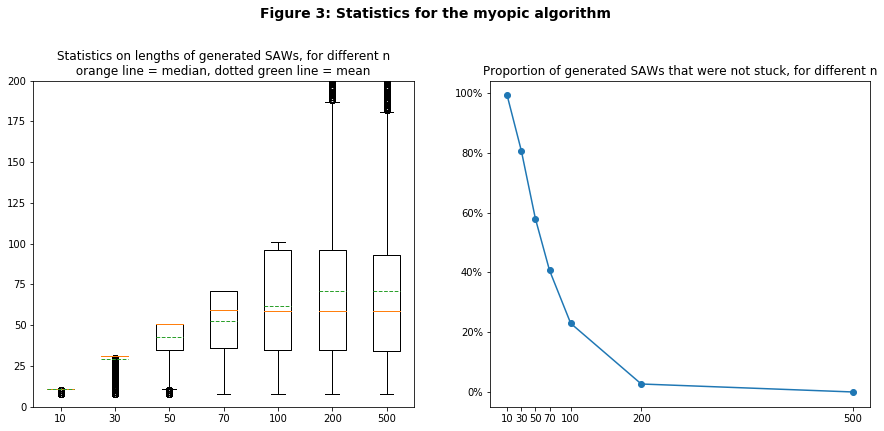

In [4]:
def myopic_benchmark(n, samples):
    """
    Samples walks from the myopic algorithm and stores their length
    
    Args:
        n (int): the length of the walk
        samples (int): number of walks to sample from the myopic algorithm
    Returns:
        (fails, lengths) (list, list): 
            fails is a list of 0's and 1's. 1 if the walk was stuck
            lengths stores the length of each generated walk
    """    
    fails = []
    lengths = []
    for _ in range(samples):
        _, _, stuck, steps = myopic_saw(n)
        fails.append(stuck)
        lengths.append(steps)
    return (fails, lengths)

n_list = [10,30,50,70,100,200,500]
results_success, results_lengths = [], []
for n in n_list:
    fails, lengths = myopic_benchmark(n, 10000)
    results_success.append(100*(1-np.mean(fails)))
    results_lengths.append(lengths)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

bp = ax1.boxplot(results_lengths, meanline = True, showmeans = True)
ax1.set_xticklabels([str(n) for n in n_list])
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(0, 200)
ax1.set_title('Statistics on lengths of generated SAWs, for different n' 
              + '\n orange line = median, dotted green line = mean ')
#ax1.set_title('Statistiques sur les longueurs des MAAE générées, pour différents n' 
#             + '\n en orange la médiane, en pointillé vert la moyenne ')

ax2.set_xticks(n_list)
lp = ax2.plot(n_list, results_success, 'o-')
ax2.set_title('Proportion of generated SAWs that were not stuck, for different n')
#ax2.set_title('Proportion de MAAE non coincées, pour différents n')
ax2.yaxis.set_major_formatter(PercentFormatter())

fig.suptitle('Figure 3: Statistics for the myopic algorithm \n\n', fontsize=14, fontweight='bold', y = 1.05)

<br> <br>

<a id = "3"></a>
# Simulation via rejection sampling

<a id = "31"></a>
### Principle

Another basic method of simulation is rejection sampling. The **target distribution** is $U(\operatorname{SAW}(n))$, the uniform distribution on the set of SAWs of length $n$. The **proposal distribution** is $U(\operatorname{SRW}(n))$, the uniform distribution on the set of simple random walks of length $n$. One simply repeats draws from $U(\operatorname{SRW}(n))$ until one obtains a self-avoiding walk.

In [5]:
def is_saw(x, y, n):
    """
    Checks if walk of length n is self-avoiding
    
    Args:
        (x,y) (list, list): walk of length n
        n (int): length of the walk
    Returns:
        True if the walk is self-avoiding
    """    
    return n+1 == len(set(zip(x,y)))  #creating a set removes duplicates, so it suffices to check the size of the set

def rejection_sampling(n, samples):
    """
    Compute acceptance rate of rejection sampling
    
    Args:
        n (int): length of generated walks
        samples (int): number of simple walks generated 
    Returns:
        (float): acceptance rate
    """    
    accepted = 0
    for _ in range(samples):
        x, y = simpl_rnd_walk(n) #generates a simple random walk
        if is_saw(x, y, n): #checks if it is a SAW
            accepted += 1
    return accepted/samples

<a id = "32"></a>
### Analysis

The unconditional **acceptance probability** is of course $\displaystyle \frac{\left|\operatorname{SAW}(n)\right|}{\left|\operatorname{SRW}(n)\right|}$. Recalling the discussion in the introduction, for $d=2$ one has the estimate $$\frac{\left|\operatorname{SAW}(n)\right|}{\left|\operatorname{SRW}(n)\right|} \approx 0.65^n n^{0.34} \quad \text{up to a constant A}$$
Since the acceptance rate goes to $0$ quite fast, the rejection sampling approach is **not efficient for large $n$**.

This estimate shows that the **average time complexity** of generating a single walk of length $n$ is roughly $1.53^n n^{-0.34}$ which is **exponential in $n$**.

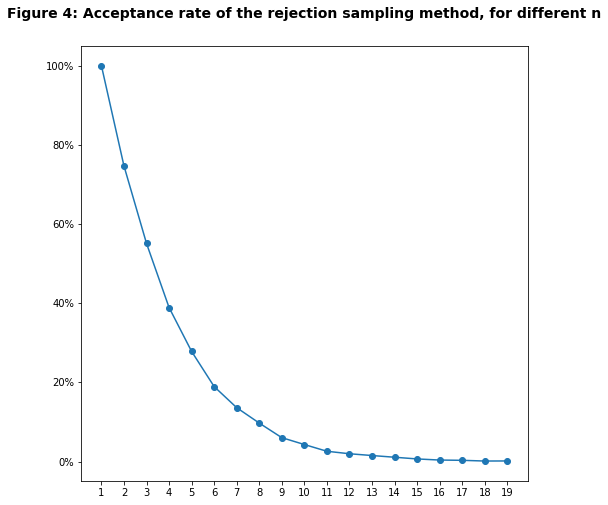

In [6]:
def plot_acceptance(n, samples):
    """
    Plots the acceptance rates for lengths 1 to n
    
    Args:
        n (int): greatest length to consider
        samples (int): number of simple walks to generate for each length
    Returns:
        Plot of the acceptance rate as a function of n
    """    
    acceptance = []
    for i in range(1, n):
        acceptance.append(rejection_sampling(i, samples)*100)
    plt.figure(figsize = (8, 8))
    plt.plot(range(1, n), acceptance, 'o-')
    ax = plt.axes()
    ax.set_xticks(list(range(1,n)))
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.title('Figure 4: Acceptance rate of the rejection sampling method, for different n', 
              fontsize=14, fontweight='bold', y = 1.05)
    plt.show()

plot_acceptance(20,10000)


<br> <br>

<a id = "4"></a>
# Estimation of end-to-end distance via importance sampling

<a id = "41"></a>
### Principle

Let $\mu$ denote the counting measure on $\operatorname{SAW}(n)$ and $f$ denote the density of $U(\operatorname{SAW}(n))$ with respect to $\mu$. Let $P$ be the probability distribution induced on $\operatorname{SAW}(n)$ by the myopic algorithm (recall how we previously computed the probabilities of two SAWs, and set mass $0$ on walks that get stuck prematurely). Let $g$ denote the density of $P$ with respect to $\mu$.

Let $S:(\mathbb Z^d)^{n+1} \to \mathbb R$ be a function. The objective is to estimate $E_f(S(X))$, the expectation of $S(X)$ where $X\sim U(\operatorname{SAW}(n))$.

The density $f$ is the constant $\displaystyle \frac{1}{\left| \operatorname{SAW}(n) \right|}$, which remains unknown. Since $f$ is **known up to a constant**, we may use **weighted importance sampling**.
***
Let $X_1,\ldots, X_m$ be i.i.d random variables with distribution $P$. The importance sampling estimator is $$\boxed{\hat S:= \frac{\sum_{i=1}^m w(X_i)S(X_i)}{\sum_{i=1}^m w(X_i)}} \quad \text{where } w(X_i) = \frac{1}{g(X_i)}$$

Let us prove that $\hat S$ is **consistent**: $$\frac 1m E_g\left(\sum_{i=1}^m w(X_i)S(X_i)\right) = E_g(w(X)S(X))=\int \frac{1}{g(x)} S(x) g(x) d\mu(x) = \left| \operatorname{SAW}(n) \right| \int S(x) \frac{1}{ \left|\operatorname{SAW}(n)\right|} d\mu(x) = \left| \operatorname{SAW}(n) \right| E_f(S(X))$$
and
$$\frac 1m E_g\left(\sum_{i=1}^m w(X_i)\right) = E_g(w(X))=\int \frac{1}{g(x)} g(x) d\mu(x) = \left| \operatorname{SAW}(n) \right|$$
By the Strong Law of Large Numbers and the continuous mapping theorem, 
$$ \frac{\sum_{i=1}^m w(X_i)S(X_i)}{\sum_{i=1}^m w(X_i)} \xrightarrow{a.s}E_f(S(X))$$

However, it is important to note that $\hat S$ is **biased for finite samples**.
***
Estimating the variance of $\hat S$ is somewhat technical. According to Theorem 9.2 in [these notes](http://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf), an **approximate variance** of $\hat S$ is $\displaystyle \frac{E_g[w(X)^2(S(X)-E_f(S(X))^2]}{m}$, an approximate **standard error** is $\displaystyle \sqrt{\sum_{i=1}^m \left[\frac{w(x_i)}{\sum_{k=1}^m w(x_k)}\right]^2(S(x_i)-\hat S)^2}$ and an approximate $95\%$ **confidence interval** for the true parameter is $$\hat S \pm 1.96 \sqrt{\frac 1m \sum_{i=1}^m \left[\frac{w(x_i)}{\sum_{k=1}^m w(x_k)}\right]^2(S(x_i)-\hat S)^2}$$
***
We apply this technique to the ***squared* end-to-end distance** of a SAW: $S(x_0,\ldots, x_n) = \|x_n-x_0\|_2^2 = \|x_n\|_2^2$. We chose the squared distance instead of the distance because it is much more common in the literature. 

In [7]:
def saw_weights(n):
    """
    Tries to generate a SAW of length n using the myopic algorithm and keeps track of its weight
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y, stuck, weights) (list, list, bool, list): 
            (x,y) is a SAW of length <= n
            stuck is 1 if the walk could not terminate
            weights is a list of inverse probabilities 
    """
    #code is almost identical to myopic_saw(n)
    x, y = [0], [0] 
    positions = set([(0,0)])
    weights = []
    stuck = 0
    for i in range(n):
        deltas = [(1,0), (0,1), (-1,0), (0,-1)]
        deltas_feasible = []
        for dx, dy in deltas:
            if (x[-1] + dx, y[-1] + dy) not in positions:
                deltas_feasible.append((dx,dy))
        if deltas_feasible:
            weights.append(len(deltas_feasible))  #add inverse probability to weights
            dx, dy = deltas_feasible[np.random.randint(0,len(deltas_feasible))]
            positions.add((x[-1] + dx, y[-1] + dy))
            x.append(x[-1] + dx)
            y.append(y[-1] + dy)
        else:
            stuck = 1
            break
    return x, y, stuck, weights


def importance_sampling(n, samples):
    """
    Estimates squared end-to-end distance of SAWs of length n by importance sampling
    
    Args:
        n (int): length of walks
        samples (int): number of SAWs to sample from myopic algorithm
    Returns:
        (estim, std, ci_inf, ci_sup) (float, float, float ,float):
            estim is the mean squared end-to-end distance in the weighted sample
            std is the approximate standard error (see expression above)
            ci_inf and ci_sup are the bounds of the 95% approximate confidence interval
    """
    saw = 0
    weight_list = []  #stores weight of each SAW
    norm_list = []  #stores squared end-to-end distance of each SAW
    while saw < samples:  
        x, y, stuck, weights = saw_weights(n)
        if not stuck:
            weight_list.append(np.prod(weights))  #computes final weight of the walk as product of its weights
            norm_list.append(x[-1]**2 + y[-1]**2)  #computes squared end-to-end distance
            saw += 1
    weight_list = np.array(weight_list)
    norm_list = np.array(norm_list)
    estim = np.sum(weight_list * norm_list) / np.sum(weight_list)  #computes estimate (vectorized)
    std = np.sqrt(np.sum( (weight_list / np.sum(weight_list))**2 * (norm_list - estim)**2 )) #computes std (vectorized)
    ci_inf = estim - 1.96 * np.sqrt(1/samples * std)
    ci_sup = estim + 1.96 * np.sqrt(1/samples * std)
    return (estim, std, ci_inf, ci_sup)    

<a id = "42"></a>
### Analysis

Rosenbluth [[4]](#6) was the first to use weighted importance sampling to estimate the squared end-to-end distance. Since then, true values have been computed by exaustive enumeration. They can be found at pages 7-8 of [these notes](https://www.acsu.buffalo.edu/~phygons/cp2/topic3/topic3-lec1.pdf). We have noticed that the **results of Rosenbluth were pretty far from these values**. For example, for $n=8$ he found an average of $18.80$, while the true value is $ 19.0128$.

The estimates we have obtained are consistent with those of Rosenbluth. We have noticed some **significant instability** when running the algorithm several times. This contradicts the standard errors, which are quite low. However, one must recall that these standard errors were only approximate.

On Figure 5 we have plotted relative errors for different values of $n$, with a sample size of $10.000$. They do not exceed $2\%$, which is quite satisfying.

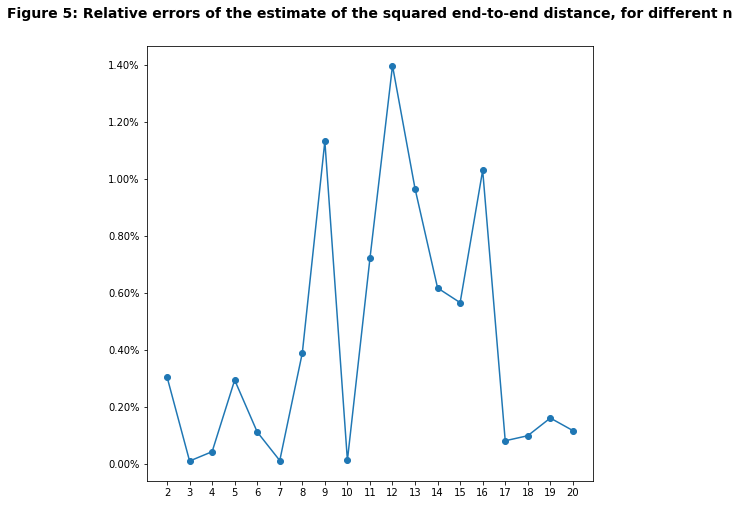

In [8]:
sq_dis = [2.66667,4.55556,7.04,9.56338,12.5744,15.5562,19.0128,22.4114,26.2425,30.0177,34.187,38.3043,42.7864,
         47.2177,51.9925,56.7164,61.7665,66.7658,72.0765] # harcoded list of true values of the mean squared distance

relative_error= []
for i in range(19):
    esti, _, _, _ = importance_sampling(i+2, 10000)
    relative_error.append(abs(esti-sq_dis[i])/sq_dis[i]*100)
plt.figure(figsize = (8, 8))
plt.plot(range(2, 21), relative_error, 'o-')
ax = plt.axes()
ax.set_xticks(list(range(2,21)))
ax.yaxis.set_major_formatter(PercentFormatter())
plt.title('Figure 5: Relative errors of the estimate of the squared end-to-end distance, for different n', 
              fontsize=14, fontweight='bold', y = 1.05)
plt.show()

<br>
<br>

<a id = "5"></a>
# Simulation via the pivot algorithm

<a id = "51"></a>
### Dimerization

Before delving into the pivot algorithm we present **dimerization**, a recursive method for generating SAWs uniformly. Its principle is quite simple: one generates **small walks** using rejection sampling (with early stopping: one does not keep growing walks that are already self-intersecting) or the myopic algorithm (which induces a uniform distribution for $n\leq 3$). **Longer walks** are obtained by a recursive call: $\text{dimer}(n) = \text{concat}\left[\text{dimer}(\lfloor \frac n2 \rfloor), \text{dimer}(n-\lfloor \frac n2 \rfloor)\right]$. It is important to note that the concatenation of two SAWs need not be a SAW, so one performs the recursive call repeatedly until the concatenation is indeed a SAW.

We have observed that using the myopic algorithm for $n\leq 3$ was much more efficient than rejection sampling (even with early stopping).

In [[2]](#6), it is proven that the algorithm induces a **uniform** distribution on $\operatorname{SAW}(n)$ and that the **time complexity** of dimerization is $\Theta(n^{c_1\log n + c_2})$ where $c_1\approx 0.17$ and $c_2\approx 0.72$, which is **much better than** the exponential complexity of **rejection sampling**.

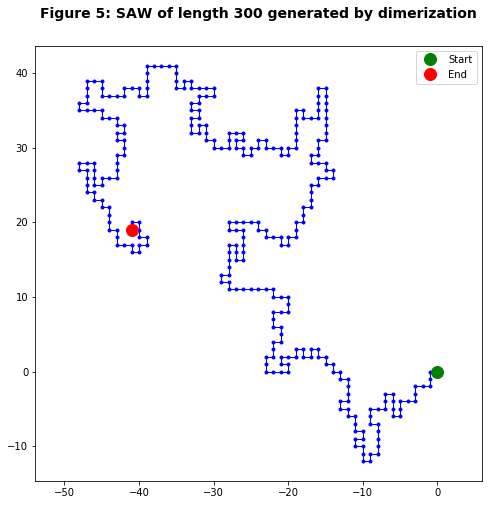

--- 1.185 seconds ---


In [9]:
def small_saw(n): 
    """
    Generates a SAW of length n by rejection sampling, with early stopping (checks at each step if walk is 
    non-intersecting. If it intersects itself, stops prematurely)
    Will be used for n<=10, hence the name small_saw
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y) (list, list): SAW of length n
    """
    #early stopping, hence more lines than previous rejection sampling
    deltas = [(1,0), (0,1), (-1,0), (0,-1)]
    not_saw = 1
    while not_saw:
        x, y = [0], [0]
        positions = set([(0,0)])
        abort = 0
        i = 0
        while i < n and not(abort):
            dx, dy = deltas[np.random.randint(0,4)]
            if (x[-1] + dx, y[-1] + dy) in positions:
                abort = 1
                break
            else:
                x.append(x[-1] + dx)
                y.append(y[-1] + dy)
                positions.add((x[-1] + dx, y[-1] + dy))
                i = i+1
        if not(abort):
            not_saw = 0
    return x, y


def dimer(n):
    """
    Generates a SAW of length n by dimerization
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y) (list, list): SAW of length n
    """
    if n <= 3:
        x, y, _, _ = myopic_saw(n) #base case uses the myopic algorithm
        return x, y
    else:
        not_saw = 1
        while not_saw:
            (x_1, y_1) = dimer(n//2)  #recursive call
            (x_2, y_2) = dimer(n-n//2)  #recursive call
            x_2 = [x + x_1[-1] for x in x_2]  #translates the second walk to the end of the first one
            y_2 = [y + y_1[-1] for y in y_2]  #translates the second walk to the end of the first one
            x_concat, y_concat = x_1 + x_2[1:], y_1 + y_2[1:]  #performs concatenation
            if is_saw(x_concat, y_concat, n):   #if walk obtained is SAW, stop
                not_saw = 0
        return x_concat, y_concat
    
def plot_dimer(n):
    """
    Plots the output of the dimerization method
    
    Args:
        n (int): the length of the walk
    Returns:
        Plot of the output of the dimerization algorithm
    """    
    x, y = dimer(n)
    plt.figure(figsize = (8, 8))
    plt.plot(x, y, 'b.-', linewidth = 1)
    plt.plot(0, 0, 'go', ms = 12, label = 'Start')
    plt.plot(x[-1], y[-1], 'ro', ms = 12, label = 'End')
    plt.axis('equal')
    plt.legend()
    plt.title('Figure 5: SAW of length ' + str(n)+ ' generated by dimerization', 
              fontsize=14, fontweight='bold', y = 1.05)
    plt.show()
    

start_time = time.time()
plot_dimer(300)
print("--- %s seconds ---" % round((time.time() - start_time), 4))
    

<a id = "52"></a>
### The pivot algorithm

The pivot algorithm is based on Markov chains: it builds a **reversible and irreducible** Markov chain on $\operatorname{SAW}(n)$. 

Let $\pi = \frac{1}{\left| \operatorname{SAW}(n) \right|}$ be the uniform probability measure on $\operatorname{SAW}(n)$. Let $P(i,j)$ denote the one-step probability transitions of the chain defined by the pivot algorithm. It is proven in [Madras] that the chain is reversible with respect to $\pi$ (since $\pi$ is a constant, this is equivalent to the symmetry of $P$). Madras also proves the chain is irreducible, therefore $\pi$ **is its stationary distribution**. 
***
Here's a **precise description** of the algorithm:
1. A SAW $W_0$ of length $n$ is generated *by some process described later*.
2. Assuming $W_t = (0,\ldots,x_n)$ has been built, consider some random $i\in \{0,\ldots, n-1\}$ and let $p = x_i$ be the pivot. Split the walk into $V_1=(0,\ldots,x_i)$ and $V_2=(x_{i+1},\ldots,x_n)$. Choose uniformly at random a matrix $A$ in the dihedral group $D_4$ and use it to pivot $V_2$ around $p$, let $V_2'$ be the transformed chunk.
3. If the concatenation of $V_1$ and $V_2'$ is a SAW, let $W_{t+1}$ be their concatenation. If not, let $W_{t+1} = W_t$.
4. Increase $t$ by $1$ and go to step 2.

There is still one obscure point. **How does one initialize the algorithm ?** In other words, how does one generate a SAW of arbitraty length ? There are two possible answers. One may **sample uniformly** a walk from $\left| \operatorname{SAW}(n) \right|$. This can be done in $\Theta(n^{c_1\log n + c_2})$ as seen above. Because the initial walk has been sampled uniformly, the Markov chain is **already in its stationary distribution**. However this approach is not tractable as $n$ goes large. **For big $n$**, one may rather start from a trivial SAW (a straight rod for example), and wait until the Markov chain reaches its stationary distribution. According to [[3]](#6), a good rule of thumb is to discard the first $10\cdot n^{1.19}$ samples (this correponds to the **burn-in** step).
***
The pivot algorithm can be implemented efficiently, and it has been extensively used in the literature to generate many walks of length larger than $10^7$ (initialized with enhanced dimerization).

In [10]:
#definition of elements of the dihedral group
m1, m2, m3, m4 = np.array([[1,0],[0,1]]), np.array([[0,-1],[1,0]]), np.array([[-1,0],[0,-1]]), np.array([[0,1],[-1,0]])
m5, m6, m7, m8 = np.array([[1,0],[0,-1]]), np.array([[0,1],[1,0]]), np.array([[-1,0],[0,1]]), np.array([[0,-1],[-1,0]])
m_list = [m1, m2, m3, m4, m5, m6, m7, m8]

def pivot(n, samples, method):
    """
    Generates SAWs of length n using the pivot algorithm
    For this algorithm, SAWs are represented by a 2*(n+1) matrix. 
    This makes it very simple to pivot walks (via matrix multiplication)
    
    Args:
        n (int): length of the SAWs
        samples (int): length of the Markov chain to be generated
        method (string): either dimerization or a straight rod
    Returns:
        results (list): list of the resulting SAWs
    """
    results = []
    #initialization
    if method == 'dimer':
        x, y = dimer(n)
    else:
        x, y = range(0,n+1), [0 for _ in range(n+1)]  #straight horizontal rod
    walk = np.c_[x,y].T
    results.append(walk)
    #main step
    for _ in range(samples):
        i = np.random.randint(0,n)  #choose the location of the pivot uniformly at random
        m = m_list[np.random.randint(0,8)]  #choose transformation in the dihedral group uniformly at random
        walk_1, walk_2 = walk[:, 0:i+1], walk[:, i+1:]  #split walk in 2 parts
        pivot = np.vstack(walk[:, i])  #site that will be used as pivot
        walk_2 = np.dot(m, (walk_2 - pivot)) + pivot   #transform second part of the walk around the pivot
        walk_piv = np.c_[walk_1,walk_2]  #concatenate
        if np.unique(walk_piv, axis=1).shape[1] == (n+1):   #check if resulting walk is SAW
            results.append(walk_piv)  
            walk = walk_piv
        else:
            results.append(walk)
    return results

def plot_pivot(n, samples, method, i, j):
    """
    Plots SAWs generated by the pivot algorithm
    
    Args:
        n (int): length of SAWs
        samples (int): length of the Markov chain
        method (string): either dimerization or a straight rod
        i, j (int, int): plot all walks between the i-th and the j-th 
    Returns:
        Plot of SAWs generated by the pivot algorithm
    """    
    plt.figure(figsize = (10, 8))
    results = pivot(n, samples, method)
    for k in range(i,j):
        walk = results[k]
        x, y = walk[0], walk[1] 
        plt.plot(x, y, '.-', linewidth = 1)
        plt.plot(x[-1], y[-1], 'ro', ms = 12)
    plt.plot(0, 0, 'ro', ms = 12, label = 'End')
    plt.plot(0, 0, 'go', ms = 12, label = 'Start')
    plt.axis('equal')
    plt.legend()
    if method == 'dimer':
        plt.title(str(j-i) + ' SAWs of length ' + str(n) + ' generated by pivot,\n'+
                  'initialization by dimerization', 
              fontsize=14, fontweight='bold', y = 1.05)
    else:
        plt.title(str(j-i) + ' SAWs of length ' + str(n) + ' generated by pivot,\n'+
                  'initialization by a horizontal rod', 
              fontsize=14, fontweight='bold', y = 1.05)
    plt.show()

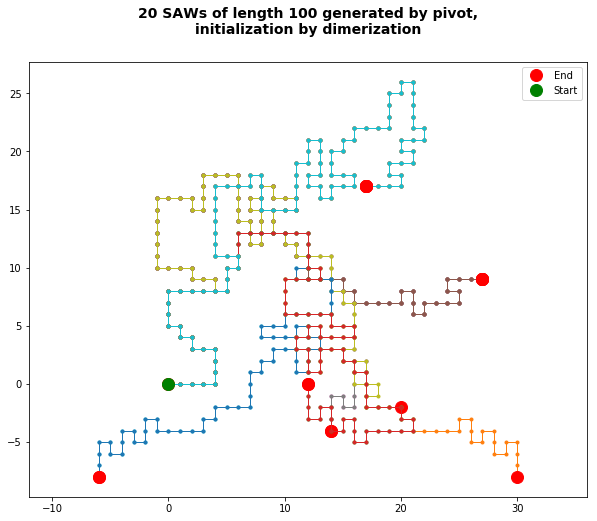

In [11]:
plot_pivot(100, 50, 'dimer', 0, 20)

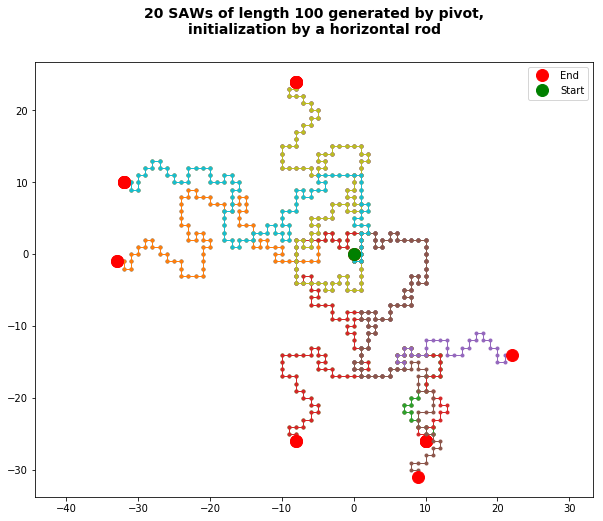

In [16]:
plot_pivot(100, 10000, 'rod', 9950, 9970)

It is interesting to note that, for the same $n$, **walks initialized with a straight rod have a much wider spatial extension**.

<a id = "53"></a>
### Use of the pivot for estimation

By the **ergodic theorem** for Markov chains, it is possible to estimate $E_f(S(X))$ using a sample generated by the pivot algorithm. However, we have not been able to find expressions for the variance of such an estimator in the literature. Therefore, we will refrain from any thorough analysis of the estimates of the squared end-to-end distance.

We have adapted the pivot algorithm to store only squared distances, instead of whole SAWs.

On Figure 6 we have plotted relative errors for different values of $n$, with a sample size of $10.000$. They sometimes reach $4\%$, which is satisfying, but worse than importance sampling. After increasing the sample size to $200.000$, relative errors are all less than $1\%$ but computations take longer (~10 minutes).

In [13]:
def pivot_estimate(n, samples, method):
    """
    Estimates squared end-to-end distance of SAWs of length n by pivot
    
    Args:
        n (int): length of walks
        samples (int): length of the Markov chain
    Returns:
        results (list): list that stores squared end-to-end distances
    """
    results = []
    if method == 'dimer':
        x, y = dimer(n)
        dist = x[-1]**2 + y[-1]**2
    else:
        x, y = range(0,n+1), [0 for _ in range(n+1)]
        dist = x[-1]**2 + y[-1]**2
    walk = np.c_[x,y].T
    results.append(dist)
    for _ in range(samples):
        i = np.random.randint(0,n)
        m = m_list[np.random.randint(0,8)]
        walk_1, walk_2 = walk[:, 0:i+1], walk[:, i+1:]
        pivot = np.vstack(walk[:, i])
        walk_2 = np.dot(m, (walk_2 - pivot)) + pivot
        walk_piv = np.c_[walk_1,walk_2]
        if np.unique(walk_piv, axis=1).shape[1] == (n+1):
            end = walk_piv[:,-1]
            results.append(np.inner(end, end))
            walk = walk_piv
        else:
            results.append(results[-1])
    return results

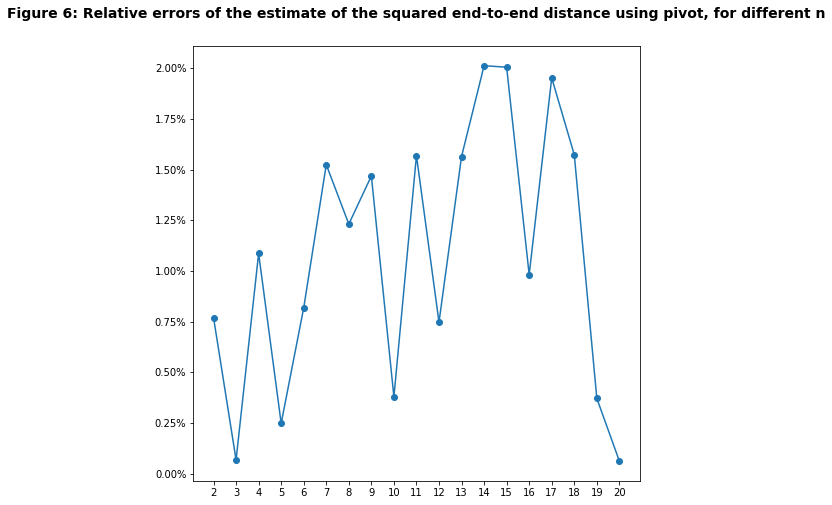

In [14]:
sq_dis = [2.66667,4.55556,7.04,9.56338,12.5744,15.5562,19.0128,22.4114,26.2425,30.0177,34.187,38.3043,42.7864,
         47.2177,51.9925,56.7164,61.7665,66.7658,72.0765] # harcoded list of true values of the mean squared distance

relative_error= []
for i in range(19):
    esti = np.mean(pivot_estimate(i+2, 10000, 'dimer'))
    relative_error.append(abs(esti-sq_dis[i])/sq_dis[i]*100)
plt.figure(figsize = (8, 8))
plt.plot(range(2, 21), relative_error, 'o-')
ax = plt.axes()
ax.set_xticks(list(range(2,21)))
ax.yaxis.set_major_formatter(PercentFormatter())
plt.title('Figure 6: Relative errors of the estimate of the squared end-to-end distance using pivot, for different n', 
              fontsize=14, fontweight='bold', y = 1.05)
plt.show()


# Bibliography
<a id = "6"></a>

[1] Liu, Jun S. *Monte Carlo strategies in scientific computing*. Springer Science & Business Media, 2008.

[2] Madras, Neal, and Gordon Slade. *The self-avoiding walk*. Springer Science & Business Media, 2013.

[3] Madras, Neal, and Alan D. Sokal. "The pivot algorithm: a highly efficient Monte Carlo method for the self-avoiding walk." *Journal of Statistical Physics* 50.1-2 (1988): 109-186.

[4] Rosenbluth, Marshall N., and Arianna W. Rosenbluth. "Monte Carlo calculation of the average extension of molecular chains." *The Journal of Chemical Physics* 23.2 (1955): 356-359.